<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [1]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter

     |████████████████████████████████| 564 kB 8.7 MB/s 
     |████████████████████████████████| 280 kB 69.8 MB/s 
     |████████████████████████████████| 48 kB 3.4 MB/s 
     |████████████████████████████████| 106 kB 9.0 MB/s 


## Install Essential Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv

from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [3]:
def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Accuracy','Train Loss','Test Accuracy','Test Loss'])
    plt.grid(True)
    
    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

## Read the Dataset

In [4]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...
Done!


## Split the Dataset

In [5]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [6]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.8)
print(f'Number of graphs in the Train Dataset: {len(train_dataset)}')
print(f'Number of graphs in the Test Dataset: {len(test_dataset)}')

Number of graphs in the Train Dataset: 150
Number of graphs in the Test Dataset: 38


## Batch Generator

In [7]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [8]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2600], x=[1174, 7], edge_attr=[2600, 4], y=[64], batch=[1174], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2468], x=[1117, 7], edge_attr=[2468, 4], y=[64], batch=[1117], ptr=[65])

Batch 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 894], x=[409, 7], edge_attr=[894, 4], y=[22], batch=[409], ptr=[23])



In [77]:
class GCN_Mean(torch.nn.Module):
    def __init__(self, hidden_channels, aggregation):
        super(GCN_Mean, self).__init__()
        torch.manual_seed(12345)
        if type(aggregation) != list:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)
        else:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels*len(aggregation), hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels*len(aggregation), hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels*len(aggregation), hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        print(x.shape)
        x = self.conv1(x, edge_index)
        print(x.shape)
        x = x.relu()
        x = self.conv2(x, edge_index)
        print(x.shape)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [78]:
class GCN_Max(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Max, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_max_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [79]:
class GCN_Add(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Add, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [80]:
class Graph_Conv(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [81]:
class Graph_Sage(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Sage, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [82]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.006,
        best_results=[0, 0, 0],
        ):
      
      super().__init__()
      self.model = model
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.best_results = best_results
    
    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss = self.criterion(out, data.y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def evaluate(self, data_loader):
        self.model.eval()

        correct, loss = 0, 0
        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss += self.criterion(out, data.y)  
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
        return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

    def train_and_evaluate(self, train_data_loader, test_data_loader, n_epochs=200):
      
      list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)
          
          train_accuracy, train_loss = self.evaluate(train_data_loader)
          list_train_acc.append(train_accuracy)
          list_train_loss.append(float(train_loss.detach()))
          
          test_accuracy, test_loss = self.evaluate(test_data_loader)
          if self.best_results[-1] + self.best_results[1] < test_accuracy + train_accuracy :
            self.best_results[0], self.best_results[1], self.best_results[-1] = epoch, train_accuracy ,test_accuracy

          list_test_acc.append(test_accuracy)
          list_test_loss.append(float(test_loss.detach()))

          print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
      
      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train Accuracy: {self.best_results[1]:.4f}, Test Accuracy: {self.best_results[-1]:.4f}')
      return list_train_acc, list_train_loss, list_test_acc, list_test_loss
      

### Mean Pooling

In [83]:
model = GCN_Mean(hidden_channels=64, aggregation=['add', 'max'])
print(model)

GCN_Mean(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(128, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [84]:
evaluate_GCN_Mean = Leaning_Evaluation(
                                   model = model,
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_Mean.train_and_evaluate(train_data_loader, test_data_loader)

Train and Evaluation started...
torch.Size([1110, 7])


RuntimeError: ignored

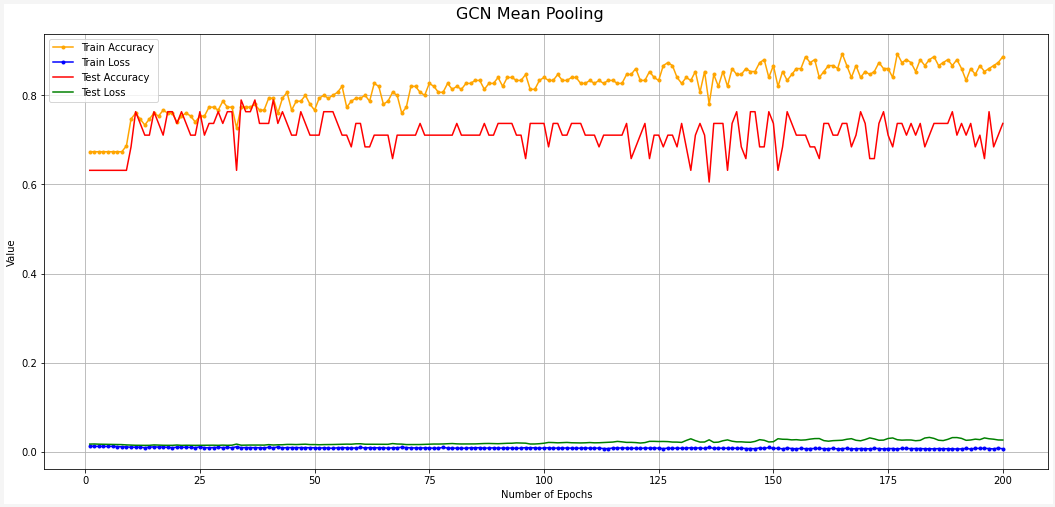

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Mean Pooling')

### Max Pooling

In [ ]:
model = GCN_Max(hidden_channels=64)
print(model)

GCN_Max(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_Max = Leaning_Evaluation(
                                   model = model,
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_Max.train_and_evaluate(train_data_loader, test_data_loader)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6733, Train Loss: 0.0128, Test Accuracy: 0.6316, Test Loss: 0.0172
Epoch: 002, Train Accuracy: 0.6733, Train Loss: 0.0120, Test Accuracy: 0.6316, Test Loss: 0.0176
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0123, Test Accuracy: 0.6316, Test Loss: 0.0170
Epoch: 004, Train Accuracy: 0.6733, Train Loss: 0.0121, Test Accuracy: 0.6316, Test Loss: 0.0169
Epoch: 005, Train Accuracy: 0.6733, Train Loss: 0.0123, Test Accuracy: 0.6316, Test Loss: 0.0167
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0123, Test Accuracy: 0.6316, Test Loss: 0.0166
Epoch: 007, Train Accuracy: 0.6733, Train Loss: 0.0119, Test Accuracy: 0.6316, Test Loss: 0.0164
Epoch: 008, Train Accuracy: 0.6733, Train Loss: 0.0115, Test Accuracy: 0.6316, Test Loss: 0.0161
Epoch: 009, Train Accuracy: 0.6733, Train Loss: 0.0111, Test Accuracy: 0.6316, Test Loss: 0.0155
Epoch: 010, Train Accuracy: 0.7000, Train Loss: 0.0105, Test Accuracy: 0.6579, Test Loss: 0.015

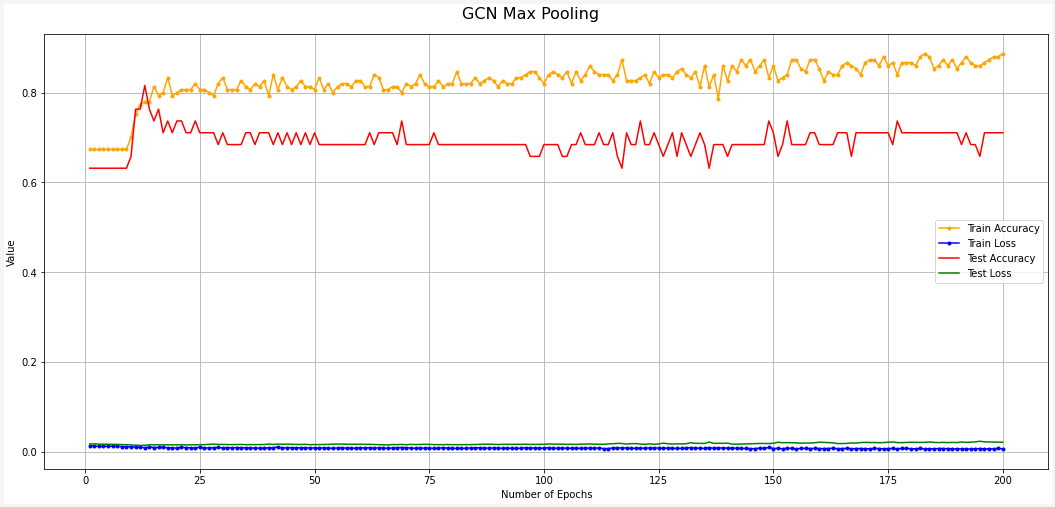

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Max Pooling')

### Add Pooling

In [ ]:
model = GCN_Add(hidden_channels=64)
print(model)

GCN_Add(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_Add = Leaning_Evaluation(
                                   model = model,
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_Add.train_and_evaluate(train_data_loader, test_data_loader)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6733, Train Loss: 0.0117, Test Accuracy: 0.6316, Test Loss: 0.0167
Epoch: 002, Train Accuracy: 0.6733, Train Loss: 0.0116, Test Accuracy: 0.6316, Test Loss: 0.0161
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0110, Test Accuracy: 0.6316, Test Loss: 0.0156
Epoch: 004, Train Accuracy: 0.6733, Train Loss: 0.0109, Test Accuracy: 0.6316, Test Loss: 0.0159
Epoch: 005, Train Accuracy: 0.6733, Train Loss: 0.0111, Test Accuracy: 0.6316, Test Loss: 0.0155
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0113, Test Accuracy: 0.6316, Test Loss: 0.0155
Epoch: 007, Train Accuracy: 0.6733, Train Loss: 0.0105, Test Accuracy: 0.6316, Test Loss: 0.0149
Epoch: 008, Train Accuracy: 0.6800, Train Loss: 0.0102, Test Accuracy: 0.6316, Test Loss: 0.0147
Epoch: 009, Train Accuracy: 0.7400, Train Loss: 0.0098, Test Accuracy: 0.7105, Test Loss: 0.0142
Epoch: 010, Train Accuracy: 0.7667, Train Loss: 0.0097, Test Accuracy: 0.7368, Test Loss: 0.014

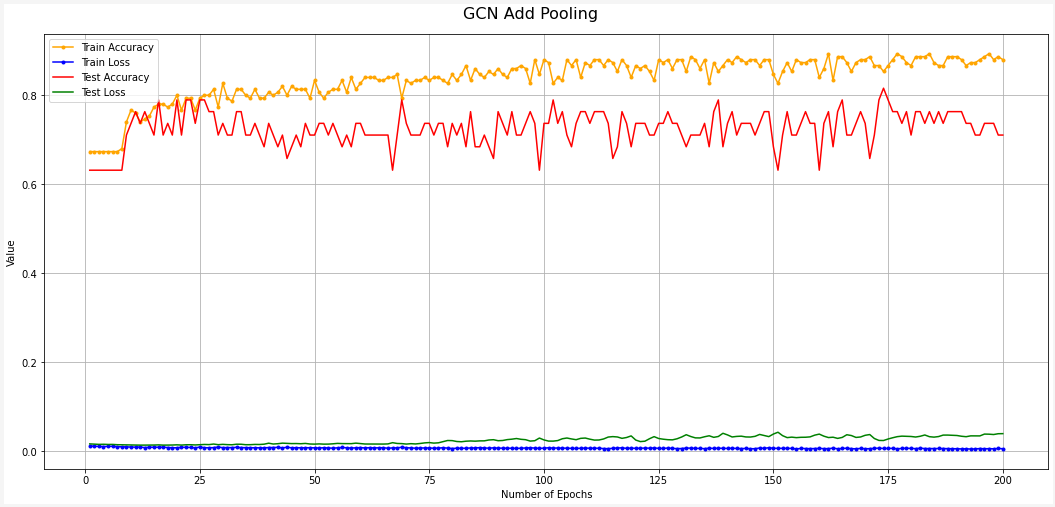

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Add Pooling')

### GraphSage

In [ ]:
model = Graph_Sage(hidden_channels=64)
print(model)

Graph_Sage(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_Graph_Sage = Leaning_Evaluation(
                                   model = model,
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_Graph_Sage.train_and_evaluate(train_data_loader, test_data_loader)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6733, Train Loss: 0.0206, Test Accuracy: 0.6316, Test Loss: 0.0301
Epoch: 002, Train Accuracy: 0.3267, Train Loss: 0.0152, Test Accuracy: 0.3684, Test Loss: 0.0200
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0127, Test Accuracy: 0.6316, Test Loss: 0.0186
Epoch: 004, Train Accuracy: 0.6733, Train Loss: 0.0124, Test Accuracy: 0.6316, Test Loss: 0.0191
Epoch: 005, Train Accuracy: 0.6733, Train Loss: 0.0119, Test Accuracy: 0.6316, Test Loss: 0.0164
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0108, Test Accuracy: 0.6316, Test Loss: 0.0157
Epoch: 007, Train Accuracy: 0.6733, Train Loss: 0.0111, Test Accuracy: 0.6316, Test Loss: 0.0157
Epoch: 008, Train Accuracy: 0.6733, Train Loss: 0.0107, Test Accuracy: 0.6316, Test Loss: 0.0156
Epoch: 009, Train Accuracy: 0.6733, Train Loss: 0.0109, Test Accuracy: 0.6316, Test Loss: 0.0158
Epoch: 010, Train Accuracy: 0.6733, Train Loss: 0.0102, Test Accuracy: 0.6316, Test Loss: 0.015

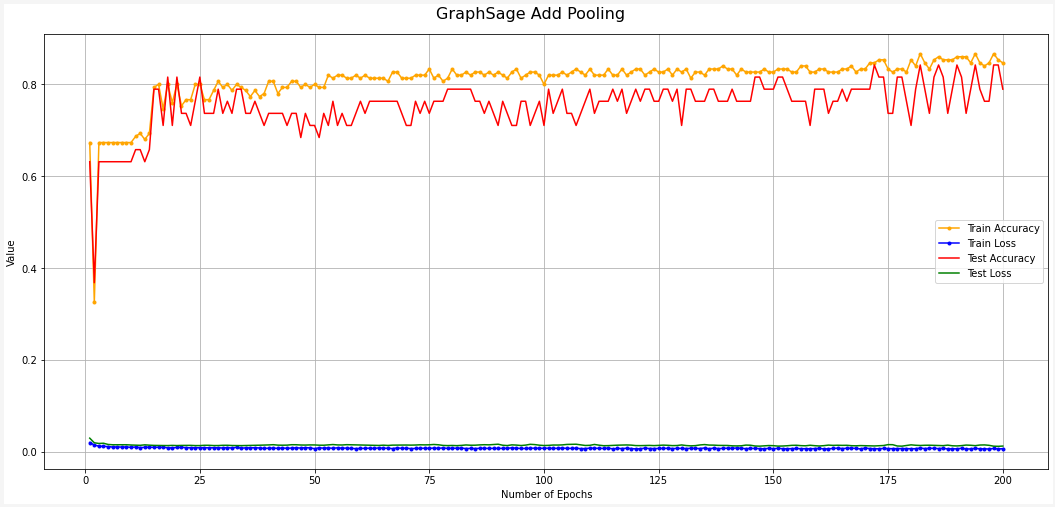

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GraphSage Add Pooling')

### GraphConv

In [ ]:
model = Graph_Conv(hidden_channels=64)
print(model)

Graph_Conv(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_Graph_Conv = Leaning_Evaluation(
                                   model = model,
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_Graph_Conv.train_and_evaluate(train_data_loader, test_data_loader)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.3267, Train Loss: 0.0735, Test Accuracy: 0.3684, Test Loss: 0.0903
Epoch: 002, Train Accuracy: 0.6733, Train Loss: 0.0368, Test Accuracy: 0.6316, Test Loss: 0.0526
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0292, Test Accuracy: 0.6316, Test Loss: 0.0431
Epoch: 004, Train Accuracy: 0.6733, Train Loss: 0.0096, Test Accuracy: 0.6316, Test Loss: 0.0146
Epoch: 005, Train Accuracy: 0.7000, Train Loss: 0.0119, Test Accuracy: 0.6316, Test Loss: 0.0163
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0097, Test Accuracy: 0.6316, Test Loss: 0.0150
Epoch: 007, Train Accuracy: 0.6733, Train Loss: 0.0104, Test Accuracy: 0.6316, Test Loss: 0.0155
Epoch: 008, Train Accuracy: 0.6733, Train Loss: 0.0097, Test Accuracy: 0.6316, Test Loss: 0.0145
Epoch: 009, Train Accuracy: 0.7200, Train Loss: 0.0111, Test Accuracy: 0.6579, Test Loss: 0.0157
Epoch: 010, Train Accuracy: 0.7200, Train Loss: 0.0094, Test Accuracy: 0.6579, Test Loss: 0.014

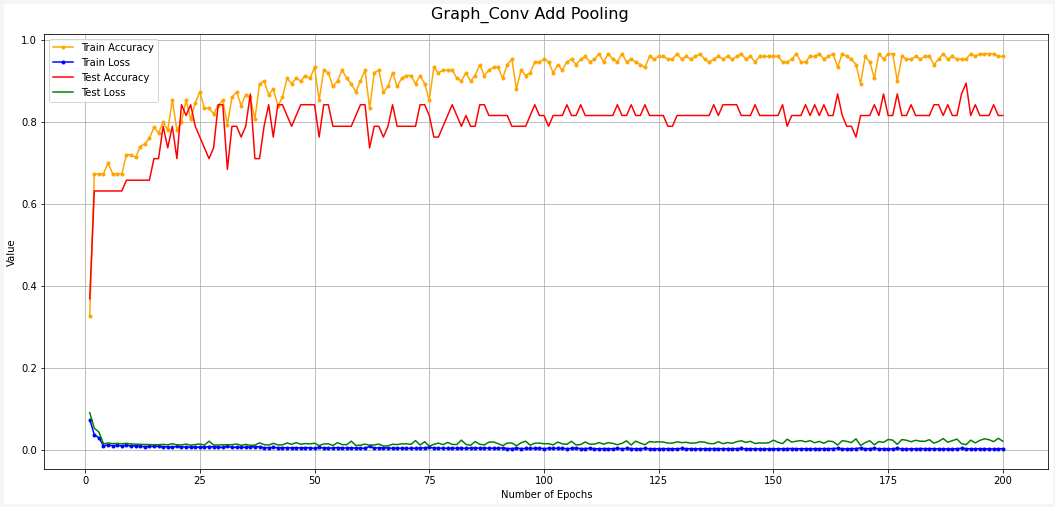

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='Graph_Conv Add Pooling')

In [ ]:
import pandas as pd

conclusion = pd.DataFrame([['GCN (Mean polling)' ,0.8933, 0.7368, 165],
              ['GCN (Max polling)',0.8933, 0.7368, 165],
              ['GCN (Add polling)',0.8867, 0.7895, 165],
              ['GraphSage (Add polling)',0.8667, 0.8421, 182],
              ['GraphConv (Add polling)',0.9533, 0.8947, 192]],
              columns=["Model Details","Train Accuracy","Test Accuracy",'Epoch with best result'])
conclusion = conclusion.set_index('Model Details')
conclusion.style.background_gradient(cmap="YlOrRd")



,Train Accuracy,Test Accuracy,Epoch with best result
Model Details,,,
GCN (Mean polling),0.893300,0.736800,165
GCN (Max polling),0.893300,0.736800,165
GCN (Add polling),0.886700,0.789500,165
GraphSage (Add polling),0.866700,0.842100,182
GraphConv (Add polling),0.953300,0.894700,192
